In [1]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline
from torchaudio import transforms as AT
from torchvision import transforms as IT

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load a pre-trained audio diffusion pipeline
device = "cuda:4" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)

unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


100%|██████████| 1000/1000 [00:28<00:00, 35.08it/s]


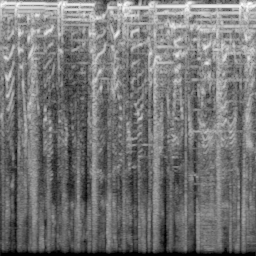

In [3]:
# Sample from the pipeline and display the outputs
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

In [4]:
# The audio array
print(output.audios[0].shape)

# The output image (spectrogram)
print(output.images[0].size)



(1, 130560)
(256, 256)


tensor(6.1201e-15) tensor(1.5653)


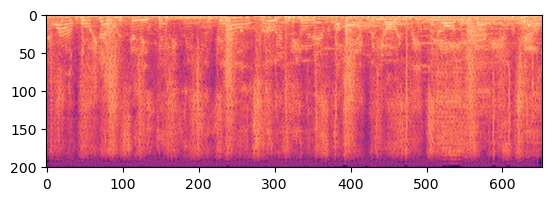

In [8]:
# Calculate and show a spectrogram for our generated audio sample using torchaudio
spec_transform = AT.Spectrogram(power=2)
spectrogram = spec_transform(torch.tensor(output.audios[0]))
print(spectrogram.min(), spectrogram.max())
log_spectrogram = spectrogram.log()
plt.imshow(log_spectrogram[0], cmap="magma")

(130560,)


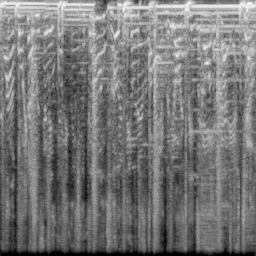

In [9]:
a = pipe.mel.image_to_audio(output.images[0])
print(a.shape)

pipe.mel.load_audio(raw_audio=a)
im = pipe.mel.audio_slice_to_image(0)
im

In [13]:
sample_rate_pipeline = pipe.mel.get_sample_rate()
print(sample_rate_pipeline)

display(Audio(output.audios[0], rate=sample_rate_pipeline*2))  # 2x speed

22050


## Fine-tuining

In [14]:
from datasets import load_dataset

dataset = load_dataset("lewtun/music_genres", split="train")
dataset

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

In [15]:
for g in list(set(dataset["genre"])):
    print(g, sum(x == g for x in dataset["genre"]))

International 814
Chiptune / Glitch 1181
Pop 945
Blues 58
Spoken 94
Easy Listening 13
Folk 1214
Rock 3095
Hip-Hop 1757
Punk 2582
Experimental 1800
Classical 495
Ambient Electronic 796
Soul-RnB 94
Jazz 306
Old-Time / Historic 408
Country 142
Instrumental 1044
Electronic 3071


In [19]:
audio_array = dataset[0]
print(audio_array)

{'audio': {'path': None, 'array': array([ 3.97140226e-07,  7.30310290e-07,  7.56406735e-07, ...,
       -1.19636677e-01, -1.16811886e-01, -1.12441722e-01]), 'sampling_rate': 44100}, 'song_id': 0, 'genre_id': 0, 'genre': 'Electronic'}


In [26]:
piece = 235
audio_array = dataset[piece]["audio"]["array"]
sample_rate_dataset = dataset[piece]["audio"]["sampling_rate"]
genre = dataset[piece]["genre"]
genre_id = dataset[piece]["genre_id"]
print("Audio array shape:", audio_array.shape)
print("Audio array genre:", genre)
print("Audio array genre_id:", genre_id)
print("Sample rate:", sample_rate_dataset)
display(Audio(audio_array, rate=sample_rate_dataset))

Audio array shape: (1321967,)
Audio array genre: Experimental
Audio array genre_id: 3
Sample rate: 44100


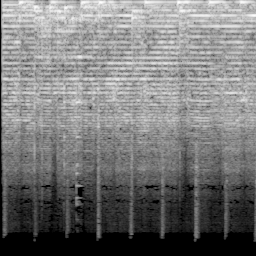

In [27]:
a = dataset[piece]["audio"]["array"]  # Get the audio array
pipe.mel.load_audio(raw_audio=a)  # Load it with pipe.mel
pipe.mel.audio_slice_to_image(0)  # View the first 'slice' as a spectrogram

In [28]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline, dtype=torch.float32)
to_t = IT.ToTensor()


def to_image(audio_array):
    audio_tensor = torch.tensor(audio_array).to(torch.float32)
    audio_tensor = resampler(audio_tensor)
    pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
    num_slices = pipe.mel.get_number_of_slices()
    slice_idx = random.randint(0, num_slices - 1)  # Pic a random slice each time (excluding the last short slice)
    im = pipe.mel.audio_slice_to_image(slice_idx)
    return im

In [29]:
def collate_fn(examples):
    # to image -> to tensor -> rescale to (-1, 1) -> stack into batch
    audio_ims = [to_t(to_image(x["audio"]["array"])) * 2 - 1 for x in examples]
    return torch.stack(audio_ims)


# Create a dataset with only the 'Chiptune / Glitch' genre of songs
batch_size = 4  # 4 on colab, 12 on A100
chosen_genre = "Electronic"  # <<< Try training on different genres <<<
indexes = [i for i, g in enumerate(dataset["genre"]) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
dl = torch.utils.data.DataLoader(
    filtered_dataset.shuffle(), batch_size=batch_size, collate_fn=collate_fn, shuffle=True
)
batch = next(iter(dl))
print(batch.shape)

torch.Size([4, 1, 256, 256])


In [ ]:
epochs = 3
lr = 1e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):

        # Prepare the input images
        clean_images = batch.to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))